WARNING (theano.configdefaults): g++ not available, if using conda: `conda install m2w64-toolchain`
WARNING (theano.configdefaults): g++ not detected ! Theano will be unable to execute optimized C-implementations (for both CPU and GPU) and will default to Python implementations. Performance will be severely degraded. To remove this warning, set Theano flags cxx to an empty string.
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


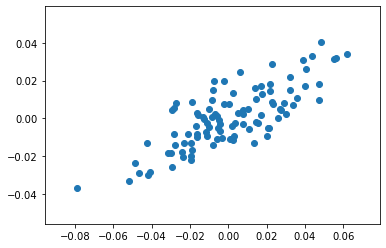

In [2]:
import pandas as pd
import numpy as np 
import pymc3 as pm
import matplotlib.pyplot as plt

df = pd.read_excel('data.xlsx', index_col=0)
df.head()
plt.scatter(df['X'], df['Y'])

In [3]:
def stock_loss(factual, predicted, coef= 100.):
    if factual * predicted < 0:
        return coef* predicted**2 + abs(factual-predicted)
    else:
        return abs(factual-predicted)

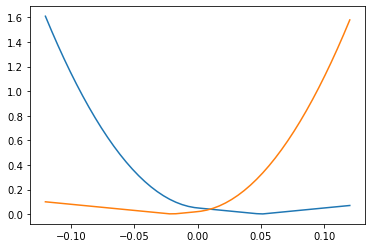

In [4]:
pred = np.linspace(-0.12, 0.12)
losses_05 = [stock_loss(0.05, p) for p in pred]
losses_02 = [stock_loss(-0.02, p) for p in pred]
plt.plot(pred, losses_05)
plt.plot(pred, losses_02)

In [10]:
import arviz as az
with pm.Model() as model:
    std = pm.Uniform("std", 0, 100)
    beta = pm.Normal("beta", mu=0, sd=100)
    alpha = pm.Normal("alpha", mu=0, sd=100)
    mean = pm.Deterministic("mean", alpha + beta * df['X'])
    obs= pm.Normal("obs", mu=mean, sd=std, observed=df['Y'])
    idata = pm.sample(1000, tune=1500)
    display(az.summary(idata))


c:\users\mikolaj\appdata\local\programs\python\python38\lib\site-packages\pymc3\sampling.py:466: FutureWarning: In an upcoming release, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  warnings.warn(
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
c:\users\mikolaj\appdata\local\programs\python\python38\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning: divide by zero encountered in log
  variables = ufunc(*ufunc_args, **ufunc_kwargs)
c:\users\mikolaj\appdata\local\programs\python\python38\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning: invalid value encountered in multiply
  variables = ufunc(*ufunc_args, **ufunc_kwargs)
c:\users\mikolaj\appdata\local\programs\python\python38\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning: invalid value encountered in log
  varia

Sampling 4 chains for 1_500 tune and 1_000 draw iterations (6_000 + 4_000 draws total) took 235 seconds.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
beta,0.469,0.038,0.396,0.538,0.001,0.0,5662.0,2988.0,1.0
alpha,0.000,0.001,-0.002,0.002,0.000,0.0,5383.0,3190.0,1.0
std,0.010,0.001,0.009,0.011,0.000,0.0,4593.0,2880.0,1.0
mean[0],-0.007,0.001,-0.010,-0.005,0.000,0.0,5301.0,2639.0,1.0
mean[1],-0.006,0.001,-0.008,-0.004,0.000,0.0,5305.0,2729.0,1.0
...,...,...,...,...,...,...,...,...,...
mean[95],0.010,0.001,0.008,0.012,0.000,0.0,5568.0,3131.0,1.0
mean[96],0.007,0.001,0.005,0.009,0.000,0.0,5570.0,3056.0,1.0
mean[97],0.021,0.002,0.017,0.024,0.000,0.0,5708.0,3000.0,1.0
mean[98],-0.024,0.002,-0.028,-0.020,0.000,0.0,5485.0,2792.0,1.0


AttributeError: module 'arviz' has no attribute 'traceplot'

c:\users\mikolaj\appdata\local\programs\python\python38\lib\site-packages\arviz\data\io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


array([<matplotlib.axes._subplots.AxesSubplot object at 0x000001F29BABB4C0>,
      dtype=object)

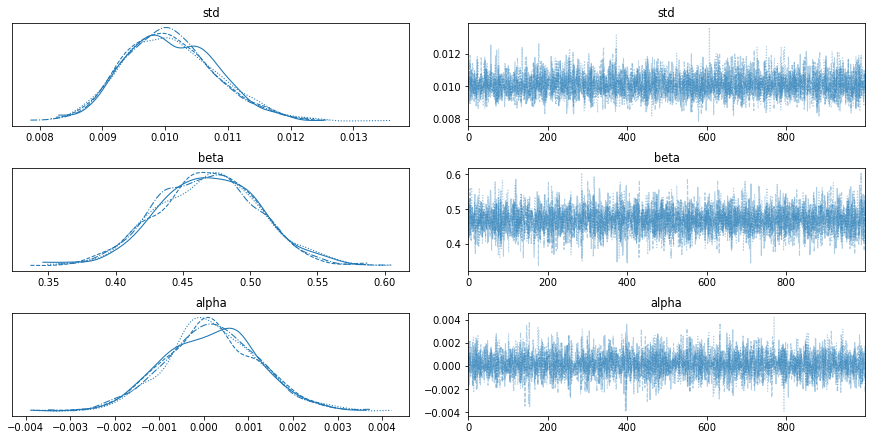

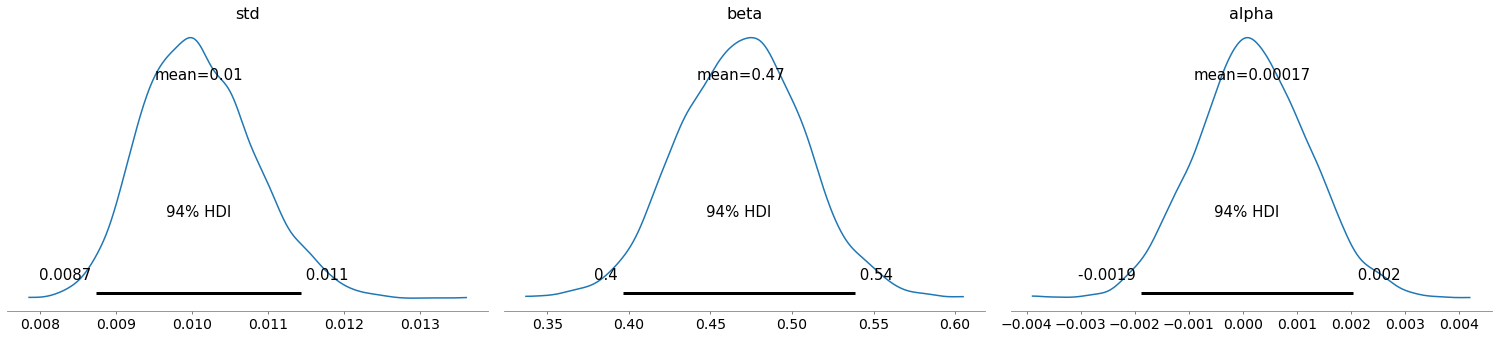

In [13]:
az.plot_trace(idata, var_names=["std", "beta", "alpha"])
az.plot_posterior(idata, var_names=["std", "beta", "alpha"])

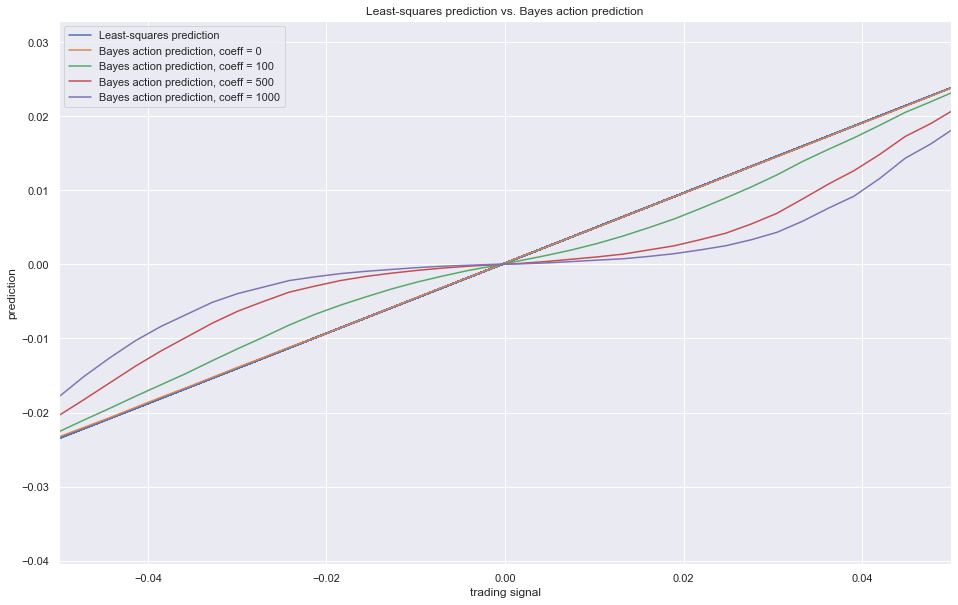

In [29]:
from scipy.optimize import fmin
import seaborn as sns
sns.set_theme()
plt.figure(figsize=(16, 10))
def stock_loss_vect(factual_vect, predicted, coef=100):
    loss_vect= np.zeros_like(factual_vect)
    ix_vect= factual_vect* predicted < 0
    loss_vect[ix_vect] = coef* predicted ** 2 + abs(factual_vect[ix_vect] -predicted)
    loss_vect[~ix_vect] = abs(factual_vect[~ix_vect] -predicted)
    return loss_vect.mean()

X = df['X']
Y = df['Y']
std_samples = idata["std"]
alpha_samples = idata["alpha"]
beta_samples = idata["beta"]

ls_coef_ = np.cov(X, Y)[0,1]/np.var(X)
ls_intercept = Y.mean() - ls_coef_*X.mean()

N = std_samples.shape[0]

noise = std_samples*np.random.randn(N) 

possible_outcomes = lambda signal: alpha_samples + beta_samples*signal + noise

plt.plot(X, ls_coef_*X + ls_intercept, label ="Least-squares prediction")
for coeff in [0, 100, 500, 1000]:

    opt_predictions = np.zeros(50)
    trading_signals =  np.linspace(X.min(), X.max(), 50)
    for i, _signal in enumerate(trading_signals):
            _possible_outcomes = possible_outcomes(_signal)
            tomin = lambda pred: stock_loss_vect(_possible_outcomes, pred, coeff)
            opt_predictions[i] = fmin(tomin, 0, disp = False)


    plt.xlabel("trading signal")
    plt.ylabel("prediction")
    plt.title(f"Least-squares prediction vs. Bayes action prediction")
    
    plt.xlim(-0.05, 0.05)
    plt.plot(trading_signals, opt_predictions, label =f"Bayes action prediction, coeff = {coeff}")
    plt.legend(loc="upper left")
    


## Conclusions
On the graph we can see the prediction whether to buy or sell depending on the trade signal. From minimising the error using least squares method, we can find the optimal parameters and see that the data can be represented by a simple linear function. 

However, when using Bayesian prediction we can define our custom loss. This custom loss has two parameters - absolute value of the difference of prediction and true value, and the quadratic coefficient times the predicted value squared. By controlling the quadratic coefficient we can manipulate the behaviour of the prediction. When coefficient is equal to zero, we get a straight line, as with the least squares method. However, when we increase the coefficient we can see the non-linearity. The quadratic value increases as the absolute value of the prediction increases. This means, that when the signal is only slightly below or above 0, the function output is very low, which can be considered as taking "no action". Only when the value is skewed more in either direction does the prediction choose to follow, eventually reaching the straight line for sufficiently high differences from zero.